In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.style.use('seaborn')
plt.style.use("dark_background")

# Quantum tunneling of a Guassian wavepacket

The purpose of this notebook is to visualise the peculiar effect of quantum tunneling using Python. This is a phenomena which allows particles to penetrate, or 'tunnel' through, a classically forbbiden barrier. 

Although one can set up and solve a *quantum tunnelling* *system* by hand fairly easily, the evolution of the solution can be difficult to visualise. So for that reason, we shall use our good friend Python to animate the process for us! 

## Basic Set Up

Suppose our particle is **initially** represented by a Gaussian wavepacket of the form:

$$
\Psi(x,t=0) \propto 
e^{\frac{(x-x_0)^2}{2\sigma^2}}e^{ik_0x},
$$ 

where $x_0$ is the initial centre of the wavepacket, $k_0$ is the initial momentum and $\sigma$ is the initial varience or 'spread' of the wavepacket.

We want to find the time-evolution of our quantum system $\Psi(x,t)$ as the particle approaches a potential barrier whose value is constant $V_0$ between $x=a$ and $a=a+w$, and zero outside of this region. 

To begin with, we note that our time-dependent wavefunction $\Psi(x,t)$ must of course satisfy the *Time Dependent Schrödinger Equation*:

$$
i\hbar\frac{\partial\Psi(x,t)}{\partial t} = \hat{H}\Psi(x,t)
$$

This equation can be solved by seperation of variables, i.e. by expressing the solution as a product of a space-dependent function and a time-depedent function: $\Psi(x,t) = X(x)\tau(t)$. If we substitute this expression into the *TDSE*, we find the **time-evolution operator** $\tau(t) = e^{-\frac{iEt}{\hbar}}$. Hence, any general state,  $\Psi(x,t)$, can be expanded in eigenstates of $H$:

$$
\Psi(x,t) = \sum_j{c_j\psi_j(x)e^{-\frac{iE_jt}{\hbar}}},
$$

where the coefficients $\|c_n\|^2$ correspond to the probability of finding the the system $\Psi(x,t)$ in an eigenstate $\psi_j$, and can be found by intergrating:

$$
c_j = \int_0^L\psi_j^\ast(x)\Psi(x,t=0)dx
$$


**Remarks**: 

 - We will use atomic units where $\hbar \rightarrow 1$ and $m   
   \rightarrow 1$.   

-  Since this is a numerical computation, we will have to *discretise* the position space of our system by making a grid of many points: $x \rightarrow$ N-point grid. As such, integrals will approximated using (Riemann) sums and differentials will be approximated using finite difference methods. 

## Steps

1. Create a discret position-space with an $N$-point grid


2. Define a function that approximate integrals in discrete space

3. Write the initial state of the system (the Guassian wavepacket): $
\Psi(x,t=0) =
e^{\frac{(x-x_0)^2}{2\sigma^2}}e^{ik_0x},
$


4. Normalise the initial state by dividing it by the root of its norm: 

$$
\Psi_{norm}(x,t=0)=\frac{\Psi(x,t=0)}{\sqrt{\|\Psi(x,t=0)\|}},        \text{  where  }    \|\Psi(x,t=0)\| = \int_0^L\Psi^\ast(x,t=0)\Psi(x,t=0)dx
$$


5. Find the energies $E_j$ and eigenstates $\psi_j(x)$ from the *Time-Independent Schrodinger Equation ($H\psi=E\psi$)*:

$$
  \left [ -\frac{\hbar^2}{2m}\frac{d^2}{dx^2} + V(x)  \right]\psi(x) = E\psi(x) ,
$$ 

where $ V(x) = V_0$ for $a \leq x \leq a+w$, and the differential operator $\frac{d^2}{dx^2}$ can be approximated by the following matrix using finite difference methods 

\begin{gather}
 \frac{d^2}{dx^2}
 =
 \frac{1}{\Delta_x^2}
  \begin{bmatrix}
   -2 &
    1 & 
    0 &
    0 &
    ... &
    \\
    1 &
    -2 &
    1 &
    0 &
    ...&
    \\
    ... &
    ... &
    ... &
    ... &
    ... &
    \\
    0 &
    ... &
    ... &
    1 &
    -2
   \end{bmatrix}
\end{gather}

7. Normalize the eigenstates $\psi_j$.


8. Find the expansion coefficients $c_j$ by integrating:

$$
c_j = \int_0^L\psi_j^\ast(x)\Psi(x,t=0)dx
$$

9. Check that the probabilities of finding the system in an energy eigenstate $\psi_j$ sum to 1:

$$
\sum_{j}\|c_n\|^2=1
$$

10. Construct the expansion of the general time-dependent state and apply the time evolution operator:

$$
\Psi(x,t) = \sum_j{c_j\psi_j(x)e^{-\frac{iE_jt}{\hbar}}}
$$

11. Find the probability amplitude of the general time-dependent state:

$$
P\left[(\Psi(x,t)\right] = \|\Psi(x,t)\| = \Psi^\ast(x,t)\Psi(x,t)
$$


12. Plot and animate the real and imaginary parts of the general state, as well as the root of its probability amplitude.

# Code:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
plt.style.use("dark_background")


class Gaussian_Wave:

    def __init__(self, N_grid, L, a, V0, w, x0, k0, sigma, t):
        self.t = t  # time values
        self.L = L  # length of grid
        self.N_grid = N_grid  # number of grid points

        self.x = np.linspace(-self.L, self.L, self.N_grid + 1)  # grid of points
        self.dx = self.x[1] - self.x[0]  # grid point spacing or 'discrete' analogue of the differential length

        def integral(f, axis=0):
            """This function allows us to approximate integrals in discrete space"""
            return np.sum(f * self.dx, axis=axis)

        self.Psi0 = np.exp(-1 / 2 * (self.x[1:-1] - x0) ** 2 / sigma ** 2) * np.exp(1j * k0 * self.x[1:-1])
        # use this range for x because as mentionned, we need the wavefunction to be 0 at the endpoints of the grid.

        # normalise the initial state
        norm = integral(np.abs(self.Psi0) ** 2)
        self.Psi0 = self.Psi0 / np.sqrt(norm)

        # kinetic energy
        self.T = -1 / 2 * 1 / self.dx ** 2 * (
                np.diag(-2 * np.ones(self.N_grid - 1)) + np.diag(np.ones(self.N_grid - 2), 1) +
                np.diag(np.ones(self.N_grid - 2), -1))

        # potential as a flat array
        self.V_flat = np.array([V0 if a < pos < a + w else 0 for pos in self.x[1:-1]])

        # potential energy as a diagonal matrix
        self.V = np.diag(self.V_flat)

        # Hamiltonian
        self.H = self.T + self.V

    # solve the eigenvalue problem and get the time-dependent wavefunction
    def animation(self):
        def integral(f, axis=0):
            """This function allows us to approximate integrals in discrete space"""
            return np.sum(f * self.dx, axis=axis)

        # get eigenvalues and eigenvectors and normalise
        E, psi = np.linalg.eigh(self.H)
        psi = psi.T
        norm = integral(np.abs(psi) ** 2)
        psi = psi / np.sqrt(norm)

        # get expansion coeffs
        c_n = np.zeros_like(psi[0], dtype=complex)

        for j in range(0, self.N_grid - 1):
            c_n[j] = integral(np.conj(psi[j]) * self.Psi0)  # for each eigenvector, compute the inner product

        # check that the probabilities sum to 1:
        sum_prob = np.linalg.norm(c_n)
        sum_prob = round(sum_prob, 3)  # round to 3 decimal places
        print("Total probability = ", sum_prob)

        # get a function that returns the time dependent wavefunction
        def Psi(t):
            return psi.T @ (c_n * np.exp(-1j * E * t))

        # get a function that returns the time dependent probabilities
        def Prob_Psi(t):
            return np.abs(Psi(t)) ** 2

        # Create figure
        fig, ax = plt.subplots(facecolor=(1, 1, 1), dpi=120)

        # Lines we wish to animate
        line1, = ax.plot([], [], lw=1, color='blue', label=r'$\Re(\Psi)$') # Real part of Psi
        line2, = ax.plot([], [], lw=1, color='green', label=r'$\Im(\Psi)$') # Imag part of Psi
        line3, = ax.plot([], [], lw=1, color='white', label=r'$\sqrt{P(\Psi)}$') # Square root of probability amplitude

        ax.plot(self.x[1:-1], self.V_flat, lw=.5, color='red', label=r'$V(x)$')  # Plot potential
        ax.fill_between(self.x[1:-1], self.V_flat, color='red', alpha=.5)  # Shade under potential
        ax.set_xlim([-self.L * 0.70, self.L * 0.70]) # set limits of x-axis
        ax.set_ylim([-0.3, .7]) # set limits of y-axis
        ax.set_xlabel(r'$x$', fontsize=15) # label of x-axis
        ax.legend(loc='best') # plot legend
        ax.grid(False) # Hide grid lines
        ax.axis('off')

        def init():
            line1.set_data([], [])
            line2.set_data([], [])
            line3.set_data([], [])
            return line1, line2, line3,

        def animate(t):
            """This is the function that we will call to animate"""

            y1 = np.real(Psi(t)) # real part of Psi
            y2 = np.imag(Psi(t)) # imaginary part of Psi
            y3 = np.sqrt(Prob_Psi(t)) # Envelope of Psi

            line1.set_data(self.x[1:-1], y1)
            line2.set_data(self.x[1:-1], y2)
            line3.set_data(self.x[1:-1], y3)

            return line1, line2, line3,


        ani = FuncAnimation(fig, animate, interval=200, frames=self.t, init_func=init, blit=True)

        return ani

Total probability =  1.0


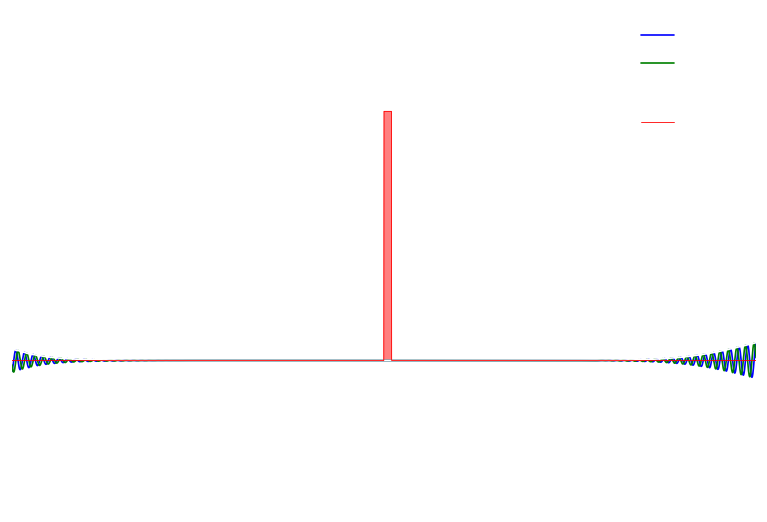

In [17]:
wavepacket = Gaussian_Wave(N_grid=5000, L=350, a=0, V0=.5,
                           w=5, x0=-200, k0=1, sigma=13, t=np.linspace(0, 600, 60))

Psi = wavepacket.animation()
HTML(Psi.to_html5_video())